In [2]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

In [3]:
data = loadmat('ex4data1.mat')

In [4]:
X, y = data['X'].T, data['y'].T
y[y==10] = 0 # set zeros equal to 0, not 10

In [5]:
def one_hot(a):
    """One hot encode variable and return its transpose: k x M , k-features, M-examples"""
    one_hot_encoded = np.zeros( (a.size, len(np.unique(a))) )
    one_hot_encoded[np.arange(a.size), a] = 1
    return one_hot_encoded.T

In [6]:
# We need to one-hot encode our output to vector
y_matrix = one_hot(y)

In [7]:
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
output_layer_size = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat('ex4/ex4weights.mat')
Theta1, Theta2 = weights['Theta1'], weights['Theta2']
# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z) )

In [9]:
def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

### Note all shapes for easier coding:
1. X - 400,5000
1. y - 10,5000
1. W1 - 25,400
1. b1 - 25,1
1. W2 - 10,25
1. b2 - 10,1

In [10]:
def forward_propagation(W1, b1, W2, b2, X):
    """feed forward nn. Returns of all layer values"""
    a1 = X
    a2 = W1@a1 + b1
    z2 = sigmoid(a2)
    a3 = W2@a2 + b2
    z3 = sigmoid(a3)
    return a1, a2, z2, a3, z3    

In [11]:
def backwards_propagations(a1, a2, z2, a3, z3, W1, W2, y, lambda_=0):
    """backwards propogation of nn"""
    m = y.shape[1]
    dZ3 = z3 - y # We find how much we missed predictions by
    
    dW2 = 1/m * dZ3@(a2.T) + (lambda_/m)*W2 ## add the regularization term
                           # We multiply how wrong our answers were(dZ3) by what values we got(a2),
                           # and get the needed adjustment. If we want to regularize, we add the term
    db2 = 1/m * np.sum(dZ3, 1) # We adjust the weight of bias based on average needed to account 
    db2 = np.reshape(db2,(db2.size,1)) # for wrong answers(dZ3). We also reshape to retain 2d matrix
    dZ2 =  W2.T@dZ3 * sigmoid_grad(z2) # We back propagate final error by multiplying it with
                                       # incoming weights to get second layer error and adjust with
                                       # cost function derivative
    # Other adjustments follow the same principle
    dW1 = 1/m * dZ2@(a1.T) + (lambda_/m)*W1
    db1 = 1/m * np.sum(dZ2, 1)
    db1 = np.reshape(db1,(db1.size,1))         
    return dW1, db1, dW2, db2

In [12]:
def init_weights(matrix_shapes):
    return [np.random.rand(i,j) for i,j in matrix_shapes]

In [13]:
def update_weights(weights, weight_deltas, alpha):
    return [w - wd*alpha for w, wd in zip(weights, weight_deltas)]

In [14]:
def prediction(z3):
    return np.argmax(z3,0)

In [15]:
def calculate_accuracy(z3,y):
    return np.sum(prediction(z3) == y) / y.size 

In [16]:
def return_wrong_example_mask(z3,y):
    return prediction(z3) != y

In [17]:
def gradient_descent(X,y, iterations, alpha=0.1, lambda_=0, X_test = None, y_test = None):
    W1, b1, W2, b2 = init_weights([(hidden_layer_size, input_layer_size), (hidden_layer_size,1),
                                  (output_layer_size,hidden_layer_size), (output_layer_size,1)])
    y_one_hot = one_hot(y)
    if X_test is not None and y_test is not None:
        y_test_one_hot = one_hot(y_test)
    
    accuracy_hist = []
    test_hist = []
        
    for i in range(iterations):
        a1, a2, z2, a3, z3 = forward_propagation(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backwards_propagations(a1, a2, z2, a3, z3, W1, W2, y_one_hot, lambda_)
        W1, b1, W2, b2 = update_weights([W1, b1, W2, b2], [dW1, db1, dW2, db2], alpha)
        
        
        if i%100==0:
            print(f"Iteration {i}, Train Accuracy: {calculate_accuracy(z3,y)}")
            accuracy_hist.append(calculate_accuracy(z3,y))
            if X_test is not None and y_test is not None:
                test_params = forward_propagation(W1, b1, W2, b2, X_test)
                print(f"Test Accuracy: {calculate_accuracy(test_params[4],y_test)}")
                test_hist.append(calculate_accuracy(test_params[4],y_test))
            
            
    return W1, b1, W2, b2, [accuracy_hist,test_hist]

In [18]:
def gradient_descent_w_cost_func(weights, X,y, alpha=0.1, lambda_=0):
    epsilon = 1e-5
    m = y.size
    W1, b1, W2, b2 = unflatten_weights(weights)
    y_one_hot = one_hot(y)
    a1, a2, z2, a3, z3 = forward_propagation(W1, b1, W2, b2, X)
    dW1, db1, dW2, db2 = backwards_propagations(a1, a2, z2, a3, z3,W1, W2, y_one_hot)
    W1, b1, W2, b2 = update_weights([W1, b1, W2, b2], [dW1, db1, dW2, db2], alpha)
    reg_term = lambda_/(2*m) * ( np.sum(np.square(W1)) + np.sum(np.square(W2)) )

    J = (-1 / m) * np.sum( (np.log(z3+epsilon) * y_one_hot) + np.log(1 - z3+epsilon) * (1 - y_one_hot) ) + reg_term
    return J, np.concatenate([w.flatten() for w in [W1, b1, W2, b2]])

In [19]:
def unflatten_weights(flat_W):
    temp_w = flat_W[:input_layer_size*hidden_layer_size]
    W1 = np.reshape(temp_w,(hidden_layer_size,input_layer_size))
    temp_w =  flat_W[input_layer_size*hidden_layer_size:]
    b1 = np.reshape(temp_w[:hidden_layer_size],(hidden_layer_size,1))
    temp_w =  temp_w[hidden_layer_size:]
    W2 = np.reshape(temp_w[:hidden_layer_size*output_layer_size],(output_layer_size,hidden_layer_size))
    temp_w = temp_w[hidden_layer_size*output_layer_size:]
    b2 = np.reshape(temp_w[:output_layer_size],(output_layer_size,1))
    
    return W1, b1, W2, b2
    

In [20]:
start_weights = init_weights([(hidden_layer_size, input_layer_size), (hidden_layer_size,1),
                                  (output_layer_size,hidden_layer_size), (output_layer_size,1)])
flat_weights = np.concatenate([w.flatten() for w in start_weights])

In [21]:
X_train, X_test, y_train, y_test = [samp.T for samp in train_test_split(X.T, y.T, test_size=0.2)]

In [22]:
options= {'maxiter': 2000}
lambda_gd = lambda w : gradient_descent_w_cost_func(w, X_train, y_train)
res = minimize(lambda_gd,
                        flat_weights,
                        jac=True,
                        method='TNC',
                        options=options)

nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
weights_fin = nn_params
tained_weights_cost = unflatten_weights(weights_fin)

In [ ]:
tained_weights_and_history = gradient_descent(X_train,y_train,10000,0.1,0,X_test,y_test)
print('------------------------')
tained_weights_and_history_regularized = gradient_descent(X_train,y_train,10000,0.1,1,X_test,y_test)

Iteration 0, Train Accuracy: 0.1
Test Accuracy: 0.105


<ipython-input-8-7b358eb7760f>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z) )


Iteration 100, Train Accuracy: 0.4795
Test Accuracy: 0.479
Iteration 200, Train Accuracy: 0.66425
Test Accuracy: 0.633
Iteration 300, Train Accuracy: 0.797
Test Accuracy: 0.716
Iteration 400, Train Accuracy: 0.83325
Test Accuracy: 0.786
Iteration 500, Train Accuracy: 0.8455
Test Accuracy: 0.796
Iteration 600, Train Accuracy: 0.856
Test Accuracy: 0.801
Iteration 700, Train Accuracy: 0.85875
Test Accuracy: 0.83
Iteration 800, Train Accuracy: 0.8685
Test Accuracy: 0.846
Iteration 900, Train Accuracy: 0.87025
Test Accuracy: 0.85
Iteration 1000, Train Accuracy: 0.8745
Test Accuracy: 0.854
Iteration 1100, Train Accuracy: 0.87875
Test Accuracy: 0.859
Iteration 1200, Train Accuracy: 0.8835
Test Accuracy: 0.865
Iteration 1300, Train Accuracy: 0.88725
Test Accuracy: 0.867
Iteration 1400, Train Accuracy: 0.88975
Test Accuracy: 0.872
Iteration 1500, Train Accuracy: 0.892
Test Accuracy: 0.873
Iteration 1600, Train Accuracy: 0.89625
Test Accuracy: 0.876
Iteration 1700, Train Accuracy: 0.89775
Test A

In [ ]:
# Trained with minimization from Sci-kit and cost function
# prediction_1 = forward_propagation(*tained_weights_cost,X_test)
# accuracy_1 = calculate_accuracy(prediction_1[4],y_test)
# print(f"Model trained with minimization scored {accuracy_1} on test set")
# For some reasone it does not work
*trained_weight_1, history_of_accuracy_1 = tained_weights_and_history
prediction_1 = forward_propagation(*trained_weight_1,X_test)
accuracy_1 = calculate_accuracy(prediction_1[4],y_test)
print(f"Model trained with manual gradient descent {accuracy_1} on test set")
*trained_weight_2, history_of_accuracy_2 = tained_weights_and_history_regularized
prediction_2 = forward_propagation(*trained_weight_2,X_test)
accuracy_2= calculate_accuracy(prediction_2[4],y_test)
print(f"Model trained with manual gradient descent and regularization {accuracy_1} on test set")

In [ ]:
plt.plot(history_of_accuracy[0])
plt.plot(history_of_accuracy[1])

We see a high accuracy and no decrease in validation(test) set after any number of itterations, thus we can conclude, that the model is propperly trained and does not overfit

Lets look at the examples the model fails to predict

In [142]:
wrong_examples = return_wrong_example_mask(prediction_1[4],y_test)

In [163]:
wrong_prediction_input = X_test[:,wrong_examples.reshape(-1)].T
wrong_prediction_output = y_test[:,wrong_examples.reshape(-1)].T

In [202]:
def see_prediction(i, o):
    sample = np.random.randint(low=0, high=len(o))
    i_samp, o_samp = i[sample], o[sample]
    example = np.reshape(i_samp,(20,20))
    plt.imshow(example)
    print(o_samp)

[9]


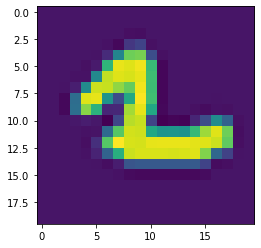

In [208]:
see_prediction(wrong_prediction_input,wrong_prediction_output)

Looking at some examples, we can clearly see that not even a human could verify that the written number corresponds to the actual value

We either have incorrect labels for some examples or corrupt dataset